In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import product
import math

from tqdm import tqdm
import warnings
from typing import Tuple

from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams['figure.figsize'] = [14, 3]

In [2]:
# загружаем датасет
df = pd.read_csv('data/raw/Netflix_Historical_StockPrice2.csv')
print(f'dataset shape: {df.shape}')
df.head()

dataset shape: (1260, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,98.339996,101.440002,97.820000,101.209999,101.209999,12432200
1,2016-03-29,101.080002,104.330002,101.000000,104.129997,104.129997,16008900
2,2016-03-30,104.650002,104.910004,101.480003,102.190002,102.190002,14705000
3,2016-03-31,102.430000,103.529999,101.050003,102.230003,102.230003,9747500
4,2016-04-01,102.930000,105.790001,102.470001,105.699997,105.699997,14182400


In [3]:
# подготовим данные
df.Date = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index(['Date'])
df = df.asfreq('M').fillna(method="ffill").sort_index()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-31,102.430000,103.529999,101.050003,102.230003,102.230003,9747500.0
2016-04-30,102.430000,103.529999,101.050003,102.230003,102.230003,9747500.0
2016-05-31,102.949997,103.449997,102.129997,102.570000,102.570000,8725700.0
2016-06-30,90.910004,91.720001,89.900002,91.480003,91.480003,9099000.0
2016-07-31,90.910004,91.720001,89.900002,91.480003,91.480003,9099000.0


<AxesSubplot:title={'center':'original'}, xlabel='Date', ylabel='Close'>

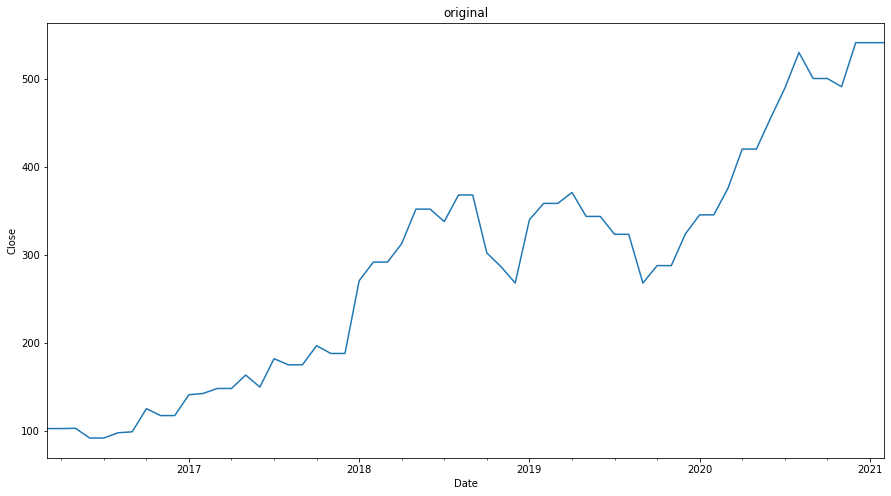

In [4]:
plt.figure(figsize=(15, 8))
plt.title('original')
plt.ylabel('Close')
df['Close'].plot()

<AxesSubplot:xlabel='Date'>

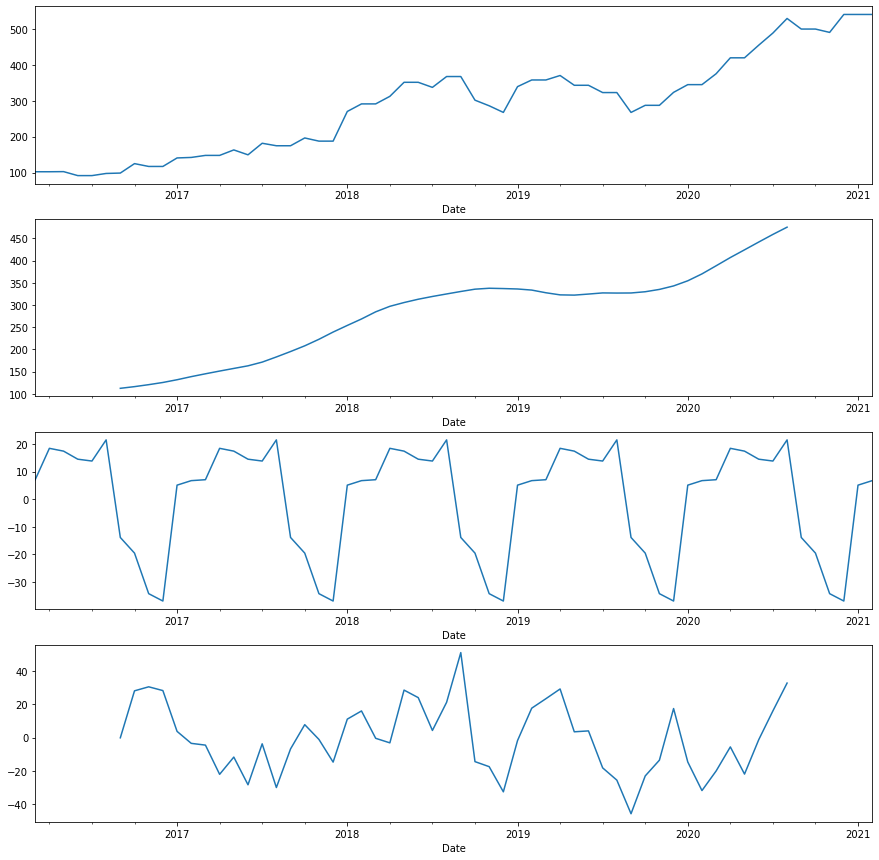

In [5]:
plt.figure(figsize=(15, 15))
decomposition = seasonal_decompose(df['Close'])

ax = plt.subplot(411)
decomposition.observed.plot(ax=ax)

ax = plt.subplot(412)
decomposition.trend.plot(ax=ax)

ax = plt.subplot(413)
decomposition.seasonal.plot(ax=ax)

ax = plt.subplot(414)
decomposition.resid.plot(ax=ax)

<AxesSubplot:xlabel='Date'>

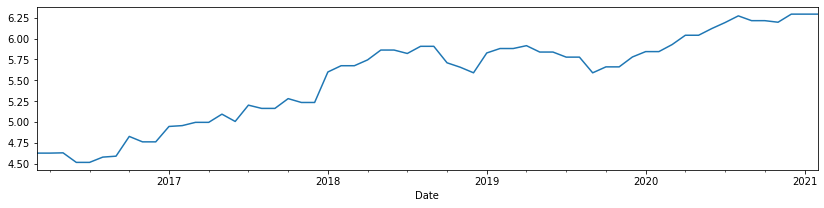

In [6]:
# удалим тренд, логорифмируем, подиференцируем по месяцам и годам

df['CloseLog'] = np.log(df['Close'])
df['CloseLog'].plot()

<AxesSubplot:xlabel='Date'>

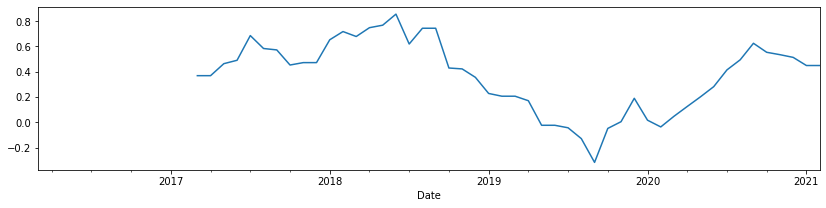

In [7]:
df['CloseLogSDiff'] = df['CloseLog'] - df['CloseLog'].shift(12)
df['CloseLogSDiff'].plot()

<AxesSubplot:xlabel='Date'>

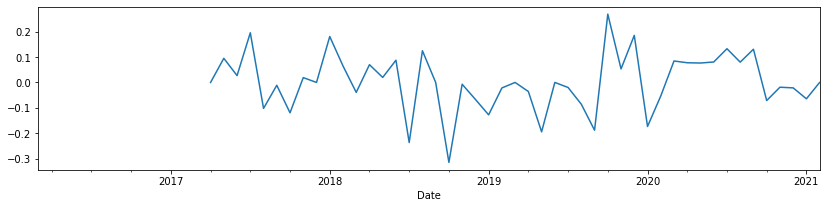

In [8]:
df['CloseLogSDiffDiff'] = df['CloseLogSDiff'] - df['CloseLogSDiff'].shift()
df['CloseLogSDiffDiff'].plot()

In [9]:
p_value = adfuller(df['CloseLogSDiffDiff'][13:])[1]
print(p_value)
if p_value < 0.05:
    print('Series is stationary')
else:
    print('Series is non-stationary')

1.3562796690319067e-09
Series is stationary


<AxesSubplot:xlabel='Date'>

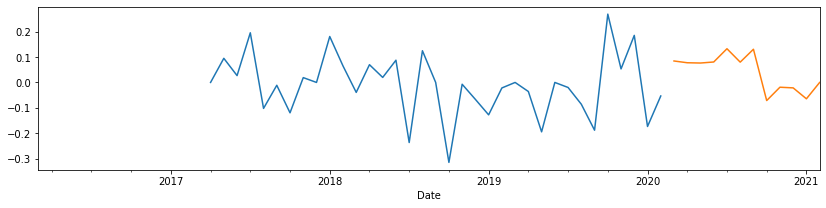

In [10]:
# y_train, y_test = train_test_split(df, test_size=0.2, random_state=0)
y_train, y_test = df[:math.floor(len(df) * 0.8)], df[math.floor(len(df) * 0.8):]

y_train['CloseLogSDiffDiff'].plot()
y_test['CloseLogSDiffDiff'].plot()

/home/rytuo/.local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


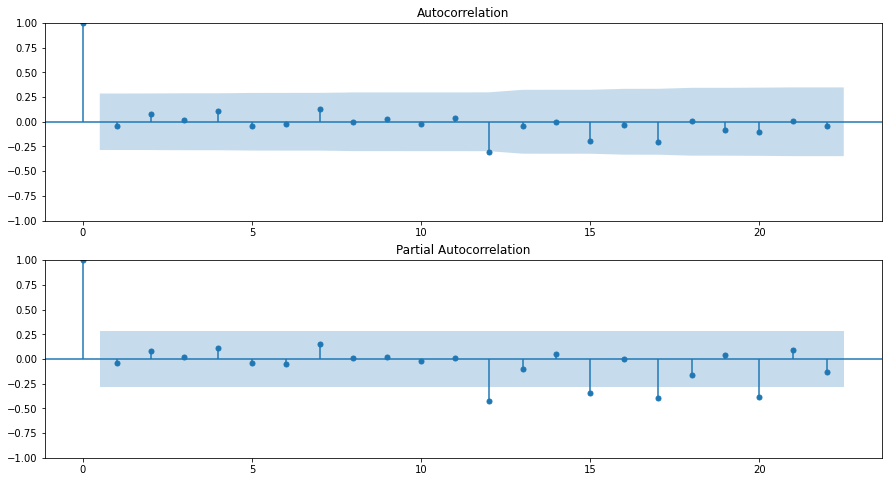

In [11]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
plot_acf(df['CloseLogSDiffDiff'][13:], lags=22, ax=ax)

ax = plt.subplot(212)
plot_pacf(df['CloseLogSDiffDiff'][13:], lags=22, ax=ax)

plt.show()

In [12]:
d = 1
D = 1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

parameters = list(product(ps, qs, Ps, Qs))
len(parameters)

64

In [13]:
%%time

best_param = (4, 1, 3, 1)

if best_param is None:
    warnings.filterwarnings('ignore')

    results = []
    best_aic = float('inf')
    for param in tqdm(parameters):
        try:
            model = sm.tsa.statespace.SARIMAX(
                y_train['CloseLog'],
                order=(param[0], d, param[1]), 
                seasonal_order=(param[2], D, param[3], 12)
            ).fit(disp=-1)
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    warnings.filterwarnings('default')
else:
    best_model = sm.tsa.statespace.SARIMAX(
                y_train['CloseLog'],
                order=(best_param[0], d, best_param[1]), 
                seasonal_order=(best_param[2], D, best_param[3], 12)
            ).fit(disp=-1)
    best_aic = best_model.aic

/home/rytuo/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/rytuo/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: user 46.4 s, sys: 54.1 s, total: 1min 40s
Wall time: 16.8 s


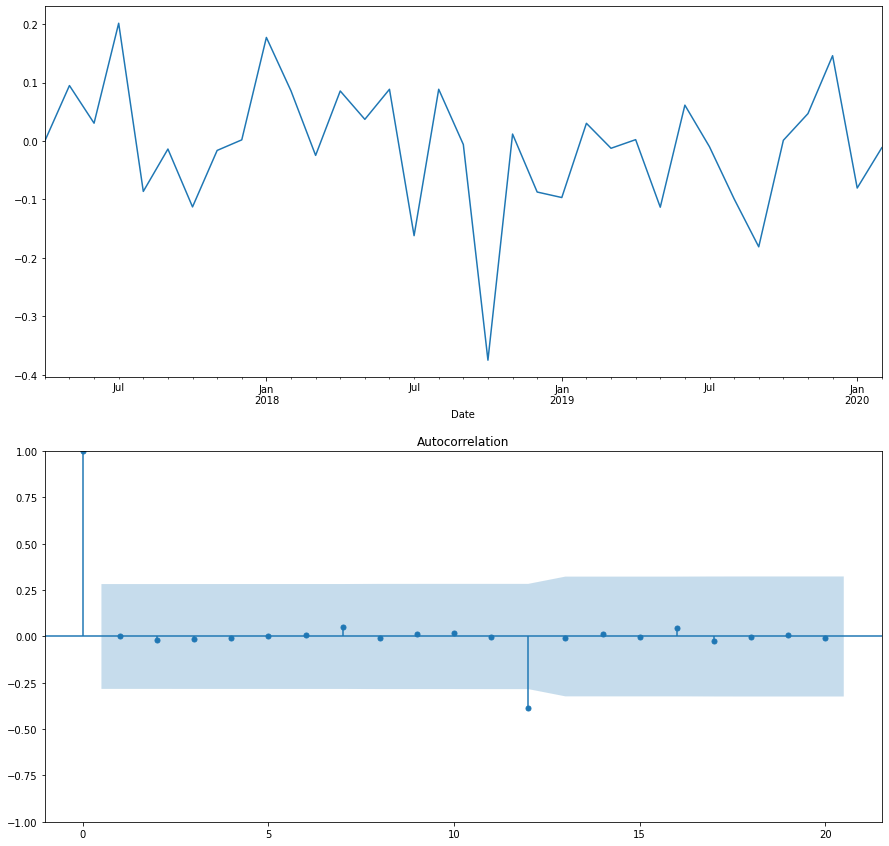

In [14]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=20, ax=ax);

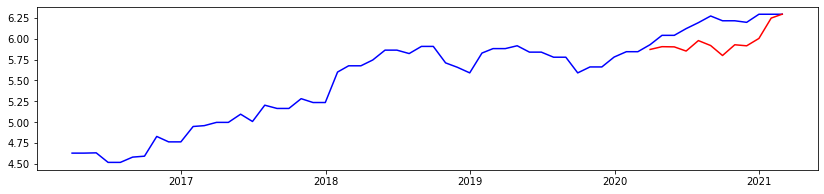

In [15]:
y_pred = pd.Series(best_model.predict(start=len(y_train), end=len(df)), index=y_test.index)
plt.plot(df['CloseLog'], c='b')
plt.plot(y_pred, c='r')
plt.show()

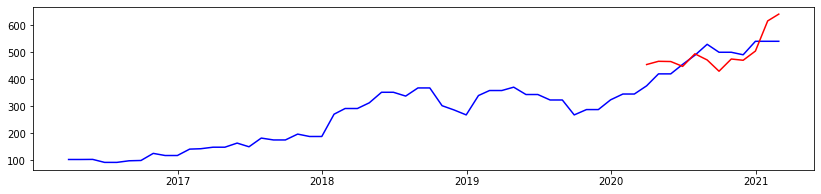

In [16]:
plt.plot(df['Close'], c='b')
plt.plot(np.exp(y_pred) + 100, c='r')

plt.show()

In [17]:
mean_absolute_percentage_error(y_test['Close'], np.exp(y_pred))

0.1812102621110626